Source: [xssChauhan/word2vec] (https://github.com/xssChauhan/word2vec/blob/master/pytorch/CBOW.ipynb)

In [61]:
import torch 
from torch.autograd import Variable 
import torch.nn as nn 
import torch.optim as optim 

import functools 

In [62]:
torch.cuda.is_available()

False

In [63]:
#CUDA = torch.cuda.is_available()
torch.manual_seed(42)


In [64]:


class CBOW(nn.Module):
    
    def __init__(self, vocabSize, embeddingSize):
        super().__init__()
        self.embedding = nn.Embedding(vocabSize, embeddingSize)
        
        #if CUDA: 
         #   self.embedding = self.embedding.cuda()
            
        self.hidden = nn.Linear(embeddingSize, vocabSize)
        self.op = nn.LogSoftmax()
        
    def forward(self, X):
        p = self.embedding(X.long())
        q = torch.mean(p, dim=0).view(1, -1)
        r = self.hidden(q)
        s = self.op(r)
        
        return s


In [65]:
def textToTrain(text, contextWindowSize):
    """
    Convert text to data for training CBOW model
    :param text: 
    :param contextWindowSize: 
    :return: 
    """
    data = []
    
    for i in range(contextWindowSize, len(text) - contextWindowSize):
        # creating context as words around the target
        context = [
            text[i + e] for e in range(-contextWindowSize, contextWindowSize + 1) 
            if i+e != i
        ]
        # target as the word at (i) in text
        target = text[i]
        
        data.append((context, target))
        
    return data 

In [66]:
# Source for text excerpt: 
# https://www.advancedwriters.com/blog/descriptive-essay-on-nature/

text = '''Man has appreciated nature and still does. He is both challenged 
and pacified by it. Not only is nature beautiful, it is every changing through 
different seasons, or timelessly unchanged in it fixed elements such as its 
great mountain ranges. It has a wild beauty to it. There is a valley in central 
Africa that when you are there it seems as if you went back in time. This is 
the Zambezi river valley that starts in the wetlands of the Okavango swamps. 
The valley is 1500 miles of wilderness, totally unspoiled by man’s encroachment. 
You see only the wildness of nature. The river flows proudly through the valley. 
It is a surging force as it goes through rocky rapids, or wide and tranquil where 
it finds space. On its banks are mud flats and reeds, where crocodiles lie in the sun, 
and further away dense trees and forests of Mopani trees, interspersed with huge grey 
prehistoric baobab trees with branches that look like roots. In the day, the sun is a 
burning yellow fire, and everything wilts under it. Even the wild life finds shade and 
lies down. As the evening comes the setting sun paints the sky with streaks of pink and 
orange, and the animals emerge.

They come individually or in groups. In the water large hippopotamus frolic, 
not intimidated by the presence of crocodiles. Nervous buck come dancing to 
the river.

Large tan colored kudu, as tall as a horse, with their white flashes and meter 
long spiral horns, smaller dark brown impala with short spiked horns, tiny 
brown duiker.

They carefully approach; stopping to be sure, no predators are near. They dip 
their heads gracefully to drink. Some suddenly will jump and struggle as a 
crocodile grabs it and drags it under the water. Elephants come and splash 
around squirting water over themselves with their long trunks, or rolling in 
the mud, which is to them a treat.

Lions eventually arrive in a pride, causing the buck to move nervously away. 
The dusk gives way to the sudden blackness of the night sky studded with silver 
stars and a huge silver moon. Soon the animals were gone; the river flows on 
into the night.

Not far away there was a noise like thunder that sounded constantly. In the 
early morning, flowing the river alive and sparkling in the sun, crocodiles 
basking in the warmth, animals drinking while it was still cool, the river 
broadened and flowed in channels around green islands. Then it fell down a 
100-meter chasm as a magnificent waterfall, 1708 meters wide. As the river 
fell down the chasm the sound was as thunder, and water spray rose high in 
the sky, white like the smoke of a bush fire. The bush is like a tropical 
forest as the spray rains down on it continually, and it is untouched by man. 
From here, it flows into a great lake and thence to the Indian Ocean.'''\
    .lower().split()

In [67]:
vocabulary = set(text)
wordToIndex = {w:i for i, w in enumerate(vocabulary)}
indexToWord = {i:w for i, w in enumerate(vocabulary)}

In [68]:
print(wordToIndex)

{'struggle': 0, 'under': 1, 'around': 2, 'then': 3, 'man.': 4, 'heads': 5, 'sound': 6, 'man': 7, 'lies': 8, 'setting': 9, 'baobab': 10, 'sky': 11, 'blackness': 12, 'individually': 13, 'wide.': 14, 'does.': 15, 'green': 16, 'went': 17, 'pride,': 18, 'lake': 19, 'dark': 20, 'swamps.': 21, 'rose': 22, 'squirting': 23, 'this': 24, 'mud,': 25, 'as': 26, 'and': 27, 'africa': 28, 'emerge.': 29, 'move': 30, 'presence': 31, 'fixed': 32, 'buck': 33, 'look': 34, 'far': 35, 'yellow': 36, 'changing': 37, 'zambezi': 38, 'further': 39, 'it.': 40, 'drink.': 41, 'wide': 42, 'man’s': 43, 'such': 44, 'smaller': 45, 'jump': 46, 'it': 47, 'horse,': 48, 'sounded': 49, 'water.': 50, 'indian': 51, 'dusk': 52, 'nervously': 53, '100-meter': 54, 'where': 55, 'will': 56, 'gives': 57, 'chasm': 58, 'streaks': 59, 'unchanged': 60, 'mountain': 61, 'rocky': 62, 'white': 63, 'goes': 64, 'comes': 65, 'crocodiles': 66, 'they': 67, 'groups.': 68, 'colored': 69, 'treat.': 70, 'while': 71, 'timelessly': 72, 'from': 73, 'sur

In [69]:
data = textToTrain(text=text, contextWindowSize=2)

In [70]:
print(len(data))

# these are (context, target) tuples in a list
data[:10] 

489


[(['man', 'has', 'nature', 'and'], 'appreciated'),
 (['has', 'appreciated', 'and', 'still'], 'nature'),
 (['appreciated', 'nature', 'still', 'does.'], 'and'),
 (['nature', 'and', 'does.', 'he'], 'still'),
 (['and', 'still', 'he', 'is'], 'does.'),
 (['still', 'does.', 'is', 'both'], 'he'),
 (['does.', 'he', 'both', 'challenged'], 'is'),
 (['he', 'is', 'challenged', 'and'], 'both'),
 (['is', 'both', 'and', 'pacified'], 'challenged'),
 (['both', 'challenged', 'pacified', 'by'], 'and')]

In [71]:
def wordsToTensor(words: list, wordToIndexMap: dict, dtype=torch.FloatTensor):
    tensor = dtype([
        wordToIndexMap[word] for word in words
    ])
    return Variable(tensor)

In [72]:
def getPrediction(contextList, model):
    model.eval()
    prediction = model(wordsToTensor(contextList, wordToIndex))
    _, index = torch.max(prediction, 1)

    # NOTE: Error resolved by changing loss.data[0] to loss.item(), and replacing
    # the .data[0] with .item() everywhere else in the code
    # SOURCE: https://github.com/NVIDIA/flownet2-pytorch/issues/113
    return indexToWord[index.item()] # indexToWord[index.data[0]]

def checkAccuracy(model):
    numCorrect = 0
    for contextList, targetWord in data:
        prediction = getPrediction(contextList, model)
        if prediction == targetWord:
            numCorrect += 1
            
    return numCorrect / len(data)

In [73]:
contextList_0, targetWord_0 = data[0]
print(data[0])

ids_0 = wordsToTensor(contextList_0, wordToIndex)
print(ids_0)

tensorTarget_0 = wordsToTensor([targetWord_0], wordToIndex, dtype=torch.LongTensor)
print(tensorTarget_0)

output_0 = model(ids_0)
print(output_0)

(['man', 'has', 'nature', 'and'], 'appreciated')
tensor([  7., 210., 139.,  27.])
tensor([110])
tensor([[-6.6626, -7.5048, -6.3472, -8.8201, -6.9979, -8.0495, -7.7435, -7.8967,
         -5.9469, -7.2949, -7.0512, -7.4076, -7.9928, -8.9345, -6.6752, -6.1814,
         -9.0166, -6.9659, -6.5144, -6.6812, -9.0080, -7.7968, -7.1836, -8.2614,
         -7.8087, -7.7930, -5.9665, -4.8754, -7.5667, -8.5778, -8.9795, -8.2457,
         -7.8315, -7.8619, -8.5298, -8.0343, -7.2662, -7.3466, -7.7854, -5.4574,
         -6.7498, -8.4609, -6.6493, -7.1231, -8.5144, -8.8930, -6.3118, -1.3392,
         -7.1463, -6.7795, -7.9025, -7.8686, -8.0860, -8.4196, -7.5942, -5.4370,
         -7.4890, -7.6500, -8.7163, -8.5615, -7.8602, -9.2361, -7.7226, -5.2372,
         -7.7405, -8.8564, -7.5169, -7.6705, -8.1726, -9.0716, -8.5006, -9.2522,
         -7.0452, -8.6023, -8.0439, -5.6648, -7.9925, -8.3382, -7.6922, -9.0511,
         -7.0260, -8.3863, -8.3005, -7.1287, -8.1380, -7.1253, -6.6792, -8.0237,
         -7.4

/development/bin/python/conda3_ana/envs/pynlp_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [74]:
### Training the model

learningRate = 0.001
NUM_EPOCHS = 1000

model = CBOW(vocabSize = len(vocabulary), embeddingSize=100)

lossFunction = torch.nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr = learningRate)
losses = []


for epoch in range(NUM_EPOCHS):
    totalLoss = 0
    
    for contextList, targetWord in data:
        ids = wordsToTensor(contextList, wordToIndex)
        targetTensor = wordsToTensor([targetWord], wordToIndex, 
                                   dtype=torch.LongTensor)
        
        model.zero_grad()
        output = model(ids)
        
        loss = lossFunction(output, targetTensor)
        loss.backward()
        optimizer.step()

        # NOTE: Error resolved by changing loss.data[0] to loss.item(), and replacing
        # the .data[0] with .item() everywhere else in the code
        # SOURCE: https://github.com/NVIDIA/flownet2-pytorch/issues/113
        totalLoss += loss.item()
        
    if epoch % 100 == 0:
        accuracy = checkAccuracy(model)
        print("Accuracy after epoch {} is {}".format(epoch, accuracy))
        
    losses.append(totalLoss)

/development/bin/python/conda3_ana/envs/pynlp_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy after epoch 0 is 0.006134969325153374


Accuracy after epoch 100 is 0.310838445807771


Accuracy after epoch 200 is 0.7300613496932515


Accuracy after epoch 300 is 0.9325153374233128


Accuracy after epoch 400 is 0.9713701431492843


Accuracy after epoch 500 is 0.9897750511247444


Accuracy after epoch 600 is 0.9918200408997955


Accuracy after epoch 700 is 0.9979550102249489


Accuracy after epoch 800 is 0.9979550102249489


Accuracy after epoch 900 is 1.0


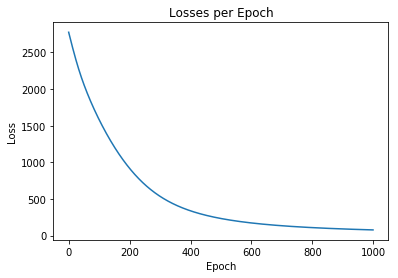

In [76]:
import matplotlib.pyplot as plt

def plotLosses(lossesList):
    fig, ax = plt.subplots(facecolor='white')
    ax.set_facecolor('white')
    ax.set_title('Losses per Epoch')
    ax.set_xlabel('Epoch')
    ax.set_ylabel("Loss")
    ax.plot(lossesList)
    plt.show()

plotLosses(losses)